# Carregamento e preparação de *datasets*

O carregamento e preparação de *datasets* é um ótimo exercício para tomarmos conhecimento das ferramentas a serem utilizadas para o processamento de sinais em `python`, seja sinais biológicos quanto de outra natureza, como um som, corrente elétrica, etc.

Nesta `notebook` será apresentado o carregamento de um *dataset* público do *website* `UCI - Machine Learning Repository`. O *dataset* a ser utilizado é o `EEG Database Data Set` (https://archive.ics.uci.edu/ml/datasets/EEG+Database).


## Descrição do *dataset*:

A intenção deste *dataset* é examinar por meio de algoritmos de inteligência computacional a pré-disposição genética que um paciente possui ao alcoolismo.

Os principais dados analizados são do tipo *time-series*, em outras palavras, conjuntos de dados que representam um sinal mensurado no domínio do tempo. Os dados são completados com outros atributos como o nome do eletrodo, o número da amostra, etc. Outras informações relevantes do *dataset*:

- Quantidade de atributos: 4
- Número de instancias: 122
- Existem dados faltantes? Sim
- Tipos de dados encontrados: categórico, inteiro e real

Existem três categorias de dados neste *dataset*:

1. Small Data Set: Contem dados do experimento realizados para pessoas alcolicas e pessoas não alcolicas
2. Large Data Set: Contem dados dividos entre TREINO e TESTE para pessoas alcolicas e não alcolicas
3. Full Data Set: <font color='red'>**descrever**</font>

Cada sessão (*trial*) é armazenada da seguinte forma:

```
# co2a0000364.rd 
# 120 trials, 64 chans, 416 samples 368 post_stim samples 
# 3.906000 msecs uV 
# S1 obj , trial 0 
# FP1 chan 0 
0 FP1 0 -8.921 
0 FP1 1 -8.433 
0 FP1 2 -2.574 
0 FP1 3 5.239 
0 FP1 4 11.587 
0 FP1 5 14.028
...
```

As primeiras 4 linhas são de cabeçalho:

**linha 1**: identificação do paciente e se ele indica ser um alcoólatra (a) ou controle (c) pela quarta letra (co2**a**0000364);

**linha 4**: determina se o paciente foi exposto a um único estímulo (`S1 obj`), a dois estímulos iguais (`S2 match`) ou a dois estímulos diferentes (`S2 no match`);

**linha 5**: identifica o início da coleta dos dados pelo eletrodo FP1. As 4 colunas são:

```
número_da_sessão identificação_do_eletrodo número_da_amostra valor_em_micro_volts
```


## Implementação

### Imports

In [1]:
from urllib.request import urlopen, urlretrieve
import os
from subprocess import getoutput as gop
import glob # get all file paths
from re import search
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas
import mne
from mne.time_frequency import psd_welch
from mne import set_eeg_reference as car
from sklearn import svm
from sklearn.preprocessing import StandardScaler

### Realizando o download 

Primeiro faremos um código para verificar se o *dataset* já foi baixado, caso contrário, executar o código de download:

In [2]:
urls = {
    'small': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/smni_eeg_data.tar.gz',
    'large_train': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TRAIN.tar.gz',
    'large_test': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TEST.tar.gz',
    'full': 'https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/eeg_full.tar'
}

# verifica se o diretório dos datasets existe
if not os.path.exists('dataset/'):
    os.mkdir('dataset/')
    for k, v in urls.items():
        fn = v.split('/')[-1]
        print('Baixando:', fn, '...')
        urlretrieve(v, './dataset/{}'.format(fn))
    print('Downlod dos datasets concluído!')
else:
    print('Dataset já baixado!')

Dataset já baixado!


### Descompactando pastas e subpastas

Agora é necessário descompactar (recursivamente) diversas pastas e subpastas em arquivos GZip. Algumas pastas estão com o arquivo na extensão `.tar`, já outras, `.tar.gz`. Não obstante, algumas subpastas estão compactadas e outras não.

In [3]:
# único arquivo somente empacotado (tar)
try:
    os.mkdir('dataset/eeg_full/')
    gop('tar -xvf dataset/eeg_full.tar -C dataset/eeg_full')
    os.remove('dataset/eeg_full.tar')

    while glob.glob('dataset/**/*.gz', recursive=True):
        # quando o arquivo está empacotado (tar) e compactado (gz)
        for f in glob.iglob('dataset/**/*.tar.gz', recursive=True):
            gop('tar -zxvf {} -C {}'.format(f, f[:f.rindex('/')]))
            os.remove(f)
        # quando o arquivo está somente compactado (gz)
        for f in glob.iglob('dataset/**/*.gz', recursive=True):
            gop('gzip -d {}'.format(f))
    print('Descompactações finalizadas!')
except:
    print("Descompactação já realizada")

Descompactação já realizada


### Carregando parte do dataset

Vamos agora carregar o subconjunto "small" do *dataset* e fica como <font color='red'>**tarefa de casa**</font> carregar e preparar todos os outros subconjuntos...

In [4]:
# organizando melhor as pastas
try:
    os.rename('dataset/smni_eeg_data', 'dataset/small')
    os.rename('dataset/eeg_full', 'dataset/full')
    os.rename('dataset/SMNI_CMI_TRAIN/', 'dataset/large_train/')
    os.rename('dataset/SMNI_CMI_TEST/', 'dataset/large_test/')
except:
    print("organização já realizada")
finally:
    print(gop('ls -l dataset/'))

organização já realizada
total 24
drwxr-xr-x   2 igornfaustino igornfaustino 4096 Apr 26 14:14 eeg_full
drwxr-xr-x 124 igornfaustino igornfaustino 4096 Apr 14 17:53 full
drwxr-xr-x  22 igornfaustino igornfaustino 4096 Oct  5  1997 large_test
drwxr-xr-x  22 igornfaustino igornfaustino 4096 Oct  5  1997 large_train
drwxr-xr-x   8 igornfaustino igornfaustino 4096 Apr 14 17:53 small
drwxr-xr-x   8 igornfaustino igornfaustino 4096 Apr 15 12:25 small_csv


### Função generica para realizar o carregamento de um dataset

In [9]:
def load_data(folder_path):
    # 1ª dimensão dos dados contendo os sujeitos. Ex.: C_1, a_m, etc
    subjects = list()
    
    ch_names = []
    create_ch_name = False

    # get all dirs inside small folder
    folder = gop('ls {}'.format(folder_path)).split('\n')
    # for all dir insider folder
    for types in folder:
        if (not os.path.isdir('{}/{}'.format(folder_path, types))):
            continue
        files = gop('ls {}/{}'.format(folder_path, types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()

        # for all file in files
        for f in files:
            arquivo = open('{}/{}/{}'.format(folder_path, types, f))
            text = arquivo.readlines()
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            # for each line inside a file
            for line in text:
                # ex: "# FP1 chan 0"
                # look if this line is a new eletrodo info
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                # ex: "0 FP1 0 -8.921"
                # or if is a data line
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)

                # if has a eeg data
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        chs.append(values)
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())

            # end for line
            # append last channel
            chs.append(values)
            create_ch_name = True
            
            # append all channels to one trial
            trials.append(chs)
            arquivo.close()
        # append all trials to one subject
        subjects.append(trials)
    return subjects, ch_names

### Função para salvar um dataset em um formato mais conhecido

In [6]:
def gen_csv(trial):
    csv_data = []
    for channels in trial:
        csv_data.append([])
        for value in channels:
            csv_data[-1].append(value)
    
    return pandas.DataFrame.from_records(csv_data).T.to_csv(index=False, header=False)

### Identificando pastas relevantes

In [10]:
# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
    'full': 'dataset/full',
}
# ------------ carregando pasta "small" ------------------

## Small Dataset

In [11]:
subjects, ch_names = load_data(folders["small"])

data = np.array(subjects)
print(data.shape)

(6, 10, 64, 256)


### Dados carregados...

Os dados "single" foram dividos da seguinte forma:
```
[experimentos, triagens, canais, amostras]
```
formando um `numpy.array` de quatro dimensões.

Em seguida, vamos plotar esses dados para "tentar" visualizar algum padrão.

### Função de Plotar Comparaçao de Trails

In [12]:
def plot_trails(data, option, depth, extension):
    
    d1 = list()
    d2 = list()
    
    if option:
        for e in range(64):
            dm0 = np.average(data[0], axis=0)
            dm1 = np.average(data[3], axis=0)

            for i, t in enumerate(np.linspace(0, 1, 256)):
                d1.append([e, t, dm0[e][i]])
                d2.append([e, t, dm1[e][i]])
    else:
        for e in range(64):
            for i, t in enumerate(np.linspace(0, 1, 256)):
                d1.append([e, t, data[0][0][e][i]])
                d2.append([e, t, data[1][0][e][i]])
    
    d1 = np.array(d1)
    d2 = np.array(d2)
    
    x1, y1, z1 = d1[:,0], d1[:,1], d1[:,2]
    x2, y2, z2 = d2[:,0], d2[:,1], d2[:,2]

    plots = list()

    plots.append([x1, y1, z1])
    plots.append([x2, y2, z2])

    fig = plt.figure(figsize=[15,6])

    for j,i in enumerate(plots,1):
        ax = fig.add_subplot(1, 2, j, projection='3d')
        surf = ax.plot_trisurf(i[0], i[1], i[2], cmap=cm.inferno, linewidth=1)
        ax.set_zlim([depth, extension])
        ax.set_xlabel('Canais')
        ax.set_ylabel('Tempo (seg.)')
        ax.set_zlabel('Milivolts')

    fig.colorbar(surf)
    fig.tight_layout()
    plt.show()

### Comparando dois Trials

Nesta etapa foi comparado duas triagens, sendo uma referente a um individuo alcolotra e outro um individo de controle

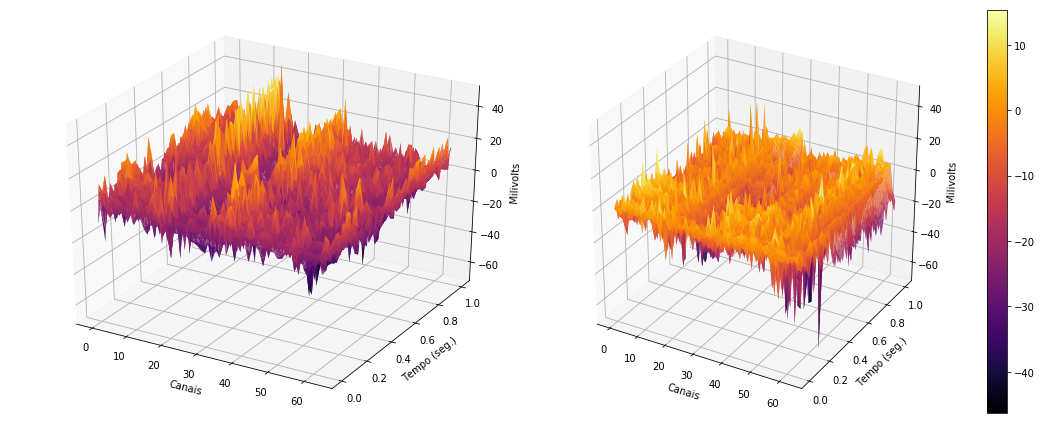

In [10]:
plot_trails(data, False, -70, 50)

### Comparando a média de todos os Trial

Nesta proxima etapa, foi plotado a média de todos os trials de um experimento de uma pessoa alcotra comparado com um individuo de controle

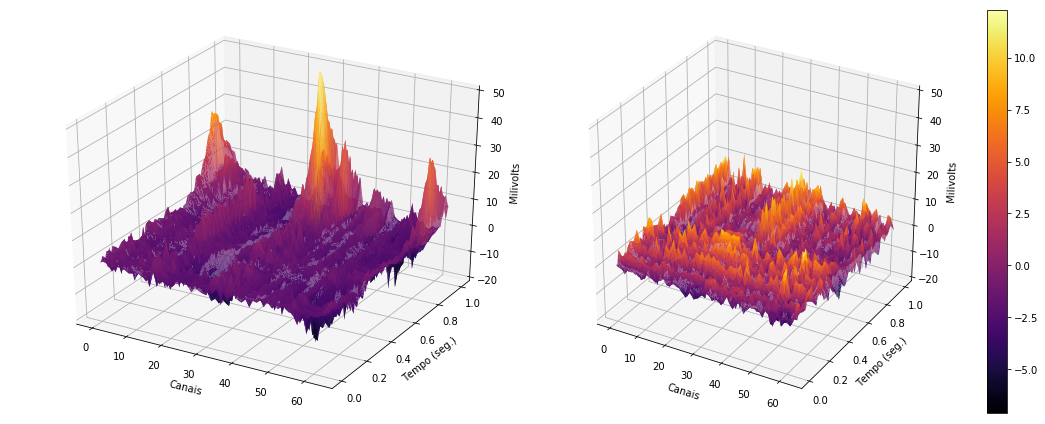

In [11]:
plot_trails(data, True, -20, 50)

### Salvar small dataset para csv

In [12]:
if not os.path.exists('dataset/small_csv/'):
    subjects_folders = ["a1co2a", "amco2a", "anco2a", "c1co2c", "cmco2c", "cnco2c"]
    folder_idx = 0

    for subject in data:
        new_folder = "dataset/small_csv/{}".format(subjects_folders[folder_idx])
        os.makedirs(new_folder)
        for idx, trial in enumerate(subject):
            f = open("{}/{}.csv".format(new_folder, idx), "w")
            f.write(gen_csv(trial))
            f.close()
        folder_idx += 1

## Pré processamento

Calculando a media dos eletrodos para um trial de controle e outro alcoolotra

In [13]:
alcoholic_average = np.average(data[0], axis=0)
crontrol_average = np.average(data[3], axis=0)

### Função de Calcular o PSD

In [16]:
def psd(ch_names, sfreq, average):
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(average, info)

    # São removidos aqui alguns canais que não parecem ser informações de eletrodos EEG
    raw.drop_channels(['x', 'nd', 'y'])

    # Aplicamos a montagem do padrão 10-20 para todos os eletrodos
 
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    return raw

### Função de plotar sinal no dominio de eletrodo no domínio do tempo

In [14]:
def plot_electrode_time_domain(raw):
    # Neste primeiro gráfico mostramos o sinal de um eletrodo no domínio do tempo
    plt.plot(np.linspace(0, 1, 256), raw.get_data()[0])
    plt.xlabel('tempo (s)')
    plt.ylabel('Dados EEG (mV/cm²)')

### Calculando o PSD de um sujeito alcoolotra, plotando o sinal de eletrodo no domíno do tempo e todos os eletrodos no domínio da frequência

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


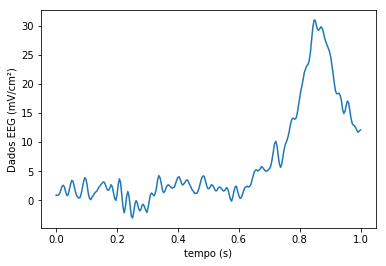

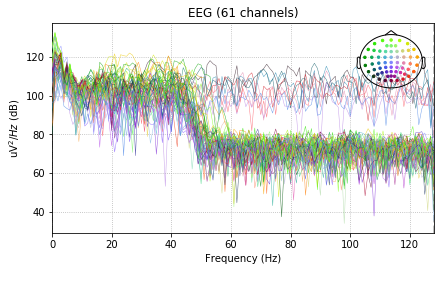

In [17]:
raw_alcoholic = psd(ch_names, 256, alcoholic_average)
plot_electrode_time_domain(raw_alcoholic)

# Aqui mostramos todos os 61 eletrodos que representam dados EEG
raw_alcoholic.plot_psd()
print()

### Calculando o PSD de um indivíduo controle, plotando o sinal de eletrodo no domíno do tempo e todos os eletrodos no domínio da frequência

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


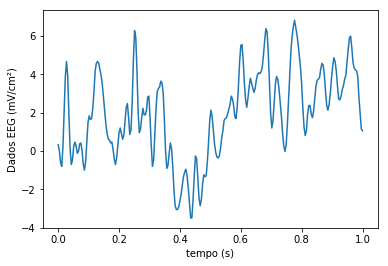

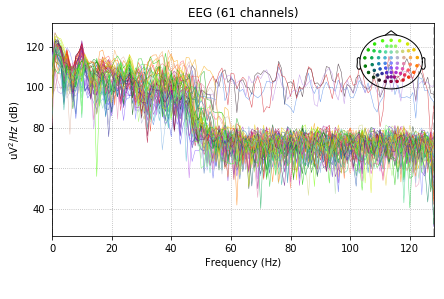

In [18]:
raw_crontrol = psd(ch_names, 256, crontrol_average)
plot_electrode_time_domain(raw_crontrol)

# Aqui mostramos todos os 61 eletrodos que representam dados EEG
raw_crontrol.plot_psd()
print()

### Encontrandos os eletrodos uteis para a analise

Foi encontrado um valor mediano que supostamente separa os eletrodos presenetes na parte superior com os da parte inferior.

Com isto, foi possivel identificar quais são os eletrodos presentes na parte superior de cada tipo de experimento (controle e alcoólatra).

Os eletrodos uteis foram todos os encontrados no individuo alcoólatra que não foram encontrados no individuo de controle.

In [19]:
psds, freqs = psd_welch(raw_crontrol)
# print(min(psd))
psd_flat = psds[:,int(len(psds[0])/2):].reshape((3965,))
min_psd = min(psd_flat)
max_psd = max(psd_flat)
n = 100;

print(min_psd, max_psd, n)
# print(max_psd)
media = np.linspace(min_psd, max_psd, n)[int(n/2)]
print(media)
# print(min_psd)

control_eletrodes = []
alcoholic_eletrodes = []

for idx, channel in enumerate(psds):
    if (max(channel[int(len(channel)/2):]) > media):
        control_eletrodes.append(raw_crontrol.ch_names[idx])

psds, freqs = psd_welch(raw_alcoholic)

for idx, channel in enumerate(psds):
    if (max(channel[int(len(channel)/2):]) > media):
        alcoholic_eletrodes.append(raw_alcoholic.ch_names[idx])

channels = list(set(alcoholic_eletrodes) - set(control_eletrodes))
print(channels)

Effective window size : 1.000 (s)
1.3187371350999301e-09 0.3311952600184292 100
0.1672703339953493
Effective window size : 1.000 (s)
['cp5', 'c4', 'c3']


### Aplicando o algoritmo CAR nos dados

['c3', 'c4', 'cp5']
Applying a custom EEG reference.
Effective window size : 1.000 (s)


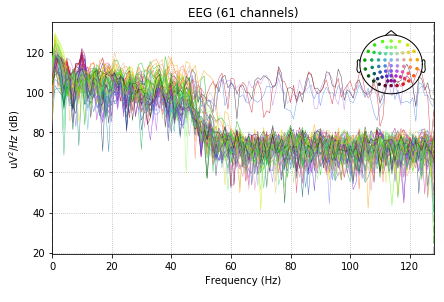


Applying a custom EEG reference.
Effective window size : 1.000 (s)


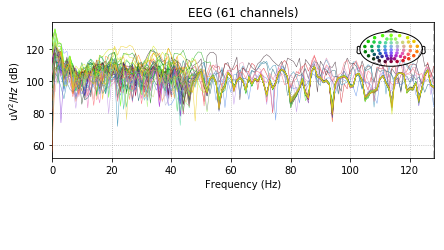

In [20]:
chs_P = [c for c in raw_crontrol.ch_names if (c in channels)]
print(chs_P)

inst, data = car(raw_crontrol, ref_channels=chs_P)

inst.plot_psd()
print()

inst, data = car(raw_alcoholic, ref_channels=chs_P)

inst.plot_psd()
print()

## Large Dataset

### Definir função para a leitura dos dados e extração das labels

In [21]:
def load_data_with_label(folder_path):
    # 1ª dimensão dos dados contendo os sujeitos. Ex.: C_1, a_m, etc
    subjects = list()
    
    ch_names = []
    create_ch_name = False
    labels = []

    # get all dirs inside folder
    folder = gop('ls {}'.format(folder_path)).split('\n')
    # for all dir insider folder
    for types in folder:
        if (not os.path.isdir('{}/{}'.format(folder_path, types))):
            continue
        l = search('^co2(?P<label>\w{1})', types)
        
        files = gop('ls {}/{}'.format(folder_path, types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()

        # for all file in files
        for f in files:
            if (l.group("label") == "a"):
                labels.append(1)
            else:
                labels.append(0)
            arquivo = open('{}/{}/{}'.format(folder_path, types, f))
            text = arquivo.readlines()
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            # for each line inside a file
            for line in text:
                # ex: "# FP1 chan 0"
                # look if this line is a new eletrodo info
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                # ex: "0 FP1 0 -8.921"
                # or if is a data line
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)

                # if has a eeg data
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        chs.append(values)
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())

            # end for line
            # append last channel
            chs.append(values)
            create_ch_name = True
            
            # append all channels to one trial
            trials.append(chs)
            arquivo.close()
        # append all trials to one subject
        subjects.append(trials)
    return subjects, ch_names, labels

In [36]:
data_train, ch_names_train, label_train = load_data_with_label(folders["large_train"])
train = np.array(data_train)
#print(train.shape)
#print(label_train)
data_test, ch_names_test, label_test = load_data_with_label(folders["large_test"])
test = np.array(data_test)
#print(test.shape)
#print(label_test)

### Comparando trails do train large

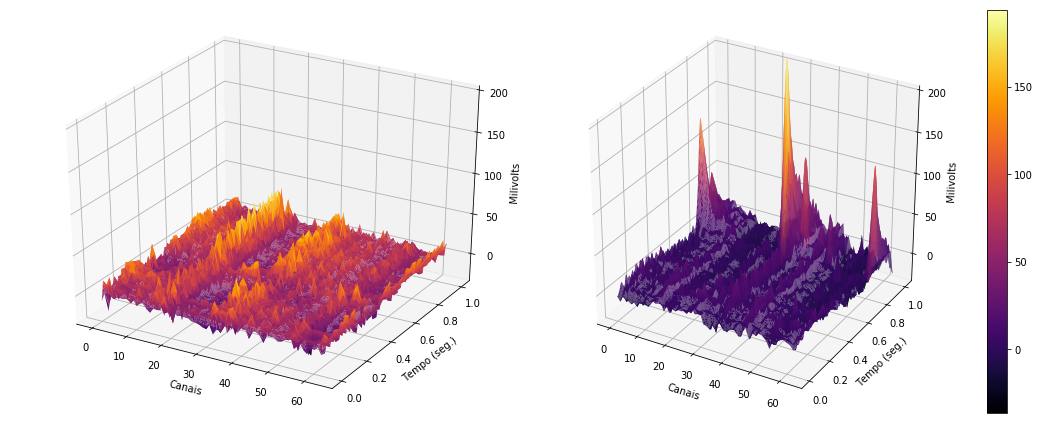

In [22]:
plot_trails(train, False, -30, 200)

### Comparando a média de todos os Trial de Treino

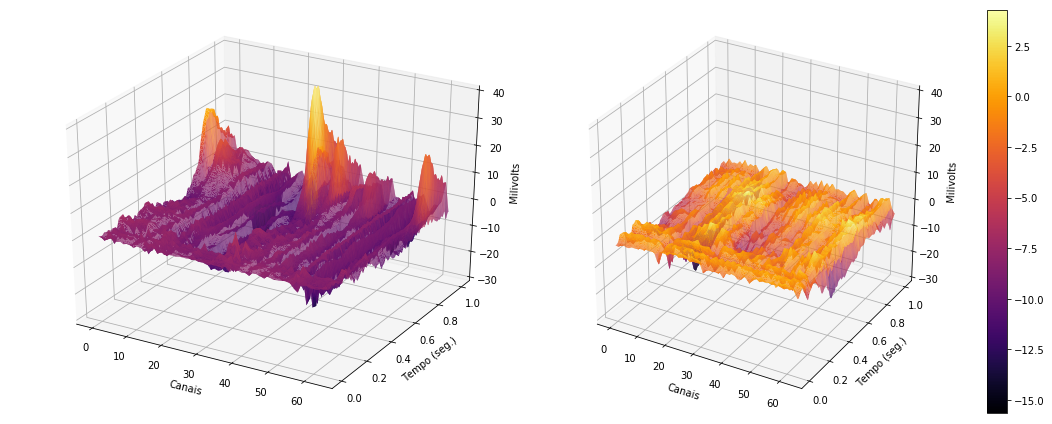

In [20]:
plot_trails(train, True, -30, 40)

### Comparando trails do test large

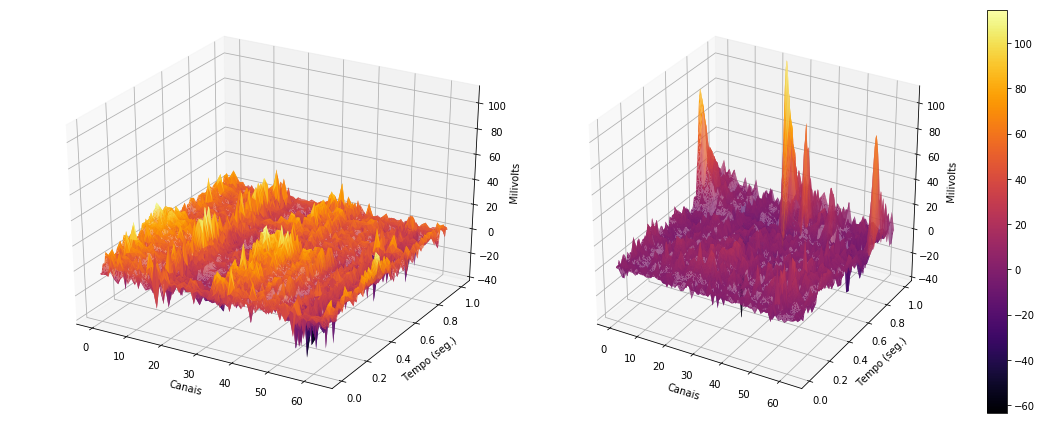

In [21]:
plot_trails(test, False, -40, 110)

### Comparando média das trials do large test

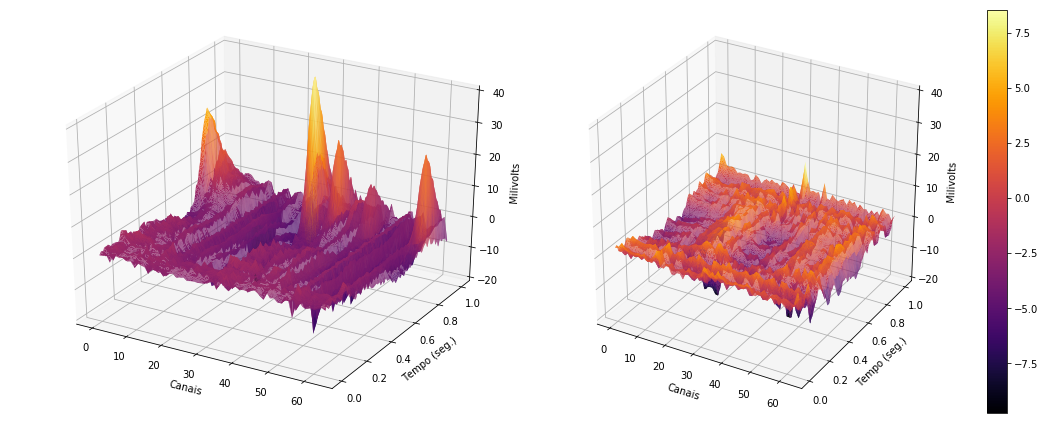

In [23]:
plot_trails(test, True, -20, 40)

### Extrair caracteristicas no dominio da frequencia

In [23]:
def feature_extract(subjects, ch_names):
    X = []
    
    eletrodos_utils = ["c3", "cp4", "cp5"]
    for idx, subject in enumerate(subjects):
        for trial in subject:
            ch_types = ['eeg'] * 64
            info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
            rawdata = mne.io.RawArray(trial, info)
            # São removidos aqui alguns canais que não parecem ser informações de eletrodos EEG
            rawdata.drop_channels(['x', 'nd', 'y'])
            inst, data = car(rawdata, ref_channels=eletrodos_utils)
            psds, freqs = psd_welch(inst)
            data = []
            for channel in psds:
                data += channel.tolist()
            X.append(data)
    return np.array(X)
        
        

## Testando o classificador sem considerar o individuo e  nem o experimento

In [27]:
X = feature_extract(data_train, ch_names_train)

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_c

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creati

Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.


    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

### Normalizar dados

In [28]:
ss = StandardScaler()
X_norm = ss.fit_transform(X)

In [29]:
cls = svm.SVC(kernel='rbf')
cls.fit(X_norm, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Testando o classificador

In [30]:
X_test = feature_extract(data_test, ch_names_test)

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_c

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creati

Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.


    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

### Normalizar dados de teste

In [34]:
ss = StandardScaler()
X_norm_test = ss.fit_transform(X_test)

In [35]:
cls.score(X_norm_test, label_test)

0.9583333333333334

## Testando o classificador  considerando o experimento

In [24]:
def load_experiments_with_label(folder_path):
    # 1ª dimensão dos dados contendo os sujeitos. Ex.: C_1, a_m, etc
    subjects_s1 = list()
    subjects_s2_m = list()
    subjects_s2_n = list()
    
    ch_names = []
    create_ch_name = False
    labels_s1 = []
    labels_s2_m = []
    labels_s2_n = []

    # get all dirs inside folder
    folder = gop('ls {}'.format(folder_path)).split('\n')
    # for all dir insider folder
    for types in folder:
        if (not os.path.isdir('{}/{}'.format(folder_path, types))):
            continue
        l = search('^co2(?P<label>\w{1})', types)
        labels.append(l.group("label"))
        files = gop('ls {}/{}'.format(folder_path, types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()

        # for all file in files
        for f in files:
            arquivo = open('{}/{}/{}'.format(folder_path, types, f))
            text = arquivo.readlines()
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            # for each line inside a file
            for line in text:
                # ex: "# FP1 chan 0"
                # look if this line is a new eletrodo info
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                # ex: "0 FP1 0 -8.921"
                # or if is a data line
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)

                # if has a eeg data
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        chs.append(values)
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())

            # end for line
            # append last channel
            chs.append(values)
            create_ch_name = True
            
            # append all channels to one trial
            trials.append(chs)
            arquivo.close()
        # append all trials to one subject
        subjects.append(trials)
    return subjects, ch_names, labels

### Função de Score do Indivíduo

In [40]:
def score(data_train, data_test, ch_names_train, ch_names_test, labels_train, labels_test):
    
    #Extração de Features
    features_train = feature_extract(data_train, ch_names_train)
    features_test = feature_extract(data_test, ch_names_test)
    
    #Normalização de Dados
    ss = StandardScaler()
    X_norm_train = ss.fit_transform(features_train)
    X_norm_test = ss.fit_transform(features_test)
    
    #Treinando a SVM
    cls = svm.SVC(kernel='rbf')
    cls.fit(X_norm_train, labels_train)
    
    #Calculando 
    score = cls.score(X_norm_test, labels_test)
    
    return score

In [39]:
score_test = score(data_train, data_test, ch_names_train, ch_names_test, label_train, label_test)
print(score_test)

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_c

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creati

Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.


    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  

    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying a custom EEG reference.
Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...  